In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = r"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\images-Dataset - Copy"

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [4]:
image_count_train = len(list(data_dir.glob('*/*.png')))
print(image_count_train)

1332


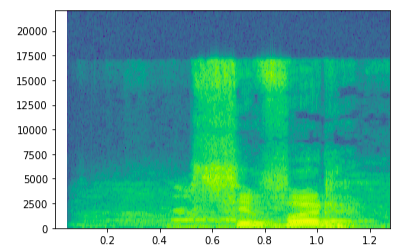

In [5]:
zero = list(data_dir.glob('0/*'))
PIL.Image.open(str(zero[0]))

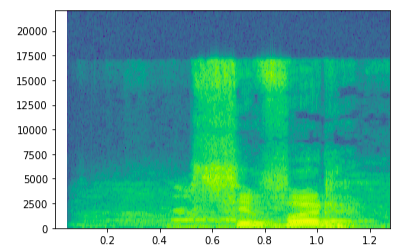

In [6]:
PIL.Image.open(str(zero[1]))

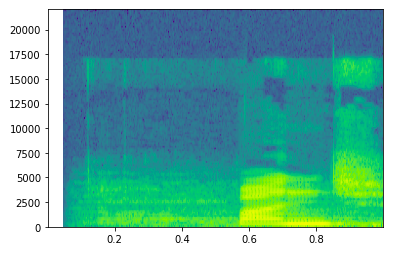

In [7]:
five = list(data_dir.glob('5/*'))
PIL.Image.open(str(five[0]))

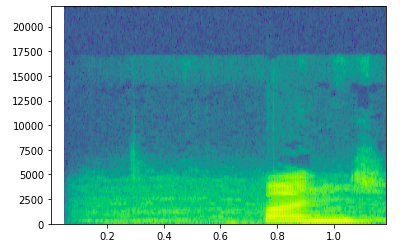

In [8]:
PIL.Image.open(str(five[7]))

In [9]:
batch_size = 32
img_height = 150
img_width = 150

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 10 classes.
Using 1066 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 10 classes.
Using 266 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


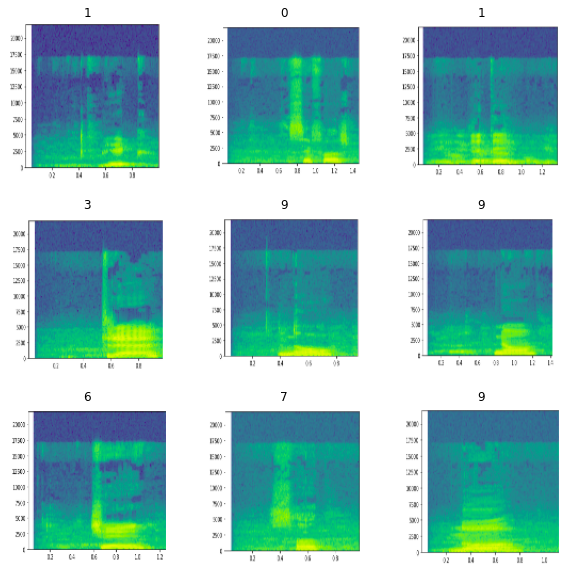

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [19]:
def conv2d(filters: int, name):
    return Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name=name)

In [20]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, ReLU
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.regularizers import l2

# fallnet architecture
model_input = Input(shape=(150, 150, 3), name='inputs')

conv1 = conv2d(16, name='convoluton_1')(model_input)
act1 = ReLU(name='activation_1')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pooling_1')(act1)

conv2 = conv2d(16, name='convolution_2')(pool1)
act2 = ReLU(name='activation_2')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pooling_2')(act2)

conv3 = conv2d(32, name='convolution_3')(pool2)
act3 = ReLU(name='activation_3')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pooling_3')(act3)

conv4 = conv2d(32, name='convolution_4')(pool3)
act4 = ReLU(name='activation_4')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2), name='pooling_4')(act4)

conv5 = conv2d(64, name='convolition_5')(pool4)
act5 = ReLU(name='activation_5')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2), name='pooling_5')(act5)

conv6 = conv2d(64, name='convolution_6')(pool5)
act6 = ReLU(name='activation_6')(conv6)
pool6 = MaxPooling2D(pool_size=(2, 2), name='pooling_6')(act6)

flat = Flatten(name='flatten')(pool6)
dense1 = Dense(32, name='dense1')(flat)
output = Dense(10, activation='sigmoid', name='output')(dense1)

model = Model(inputs=[model_input], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150, 150, 3)]     0         
                                                                 
 convoluton_1 (Conv2D)       (None, 150, 150, 16)      448       
                                                                 
 activation_1 (ReLU)         (None, 150, 150, 16)      0         
                                                                 
 pooling_1 (MaxPooling2D)    (None, 75, 75, 16)        0         
                                                                 
 convolution_2 (Conv2D)      (None, 75, 75, 16)        2320      
                                                                 
 activation_2 (ReLU)         (None, 75, 75, 16)        0         
                                                                 
 pooling_2 (MaxPooling2D)    (None, 37, 37, 16)        0     

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\haider computer s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150, 150, 3)]     0         
                                                                 
 convoluton_1 (Conv2D)       (None, 150, 150, 16)      448       
                                                                 
 activation_1 (ReLU)         (None, 150, 150, 16)      0         
                                                                 
 pooling_1 (MaxPooling2D)    (None, 75, 75, 16)        0         
                                                                 
 convolution_2 (Conv2D)      (None, 75, 75, 16)        2320      
                                                                 
 activation_2 (ReLU)         (None, 75, 75, 16)        0         
                                                                 
 pooling_2 (MaxPooling2D)    (None, 37, 37, 16)        0     

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best_CNN_80_20_1_2.hdf5',
                                  save_best_only=True,
                                  verbose=1)

In [24]:
epochs = 35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [tl_checkpoint_1]
)

Epoch 1/35


C:\Users\haider computer s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 [==============================] - ETA: 0s - loss: 4.5284 - accuracy: 0.1454
Epoch 1: val_loss improved from inf to 2.14919, saving model to tl_model_v1.weights.best_CNN_80_20_1_2.hdf5
34/34 [==============================] - 17s 475ms/step - loss: 4.5284 - accuracy: 0.1454 - val_loss: 2.1492 - val_accuracy: 0.2857
Epoch 2/35
34/34 [==============================] - ETA: 0s - loss: 2.2606 - accuracy: 0.1660
Epoch 2: val_loss did not improve from 2.14919
34/34 [==============================] - 13s 397ms/step - loss: 2.2606 - accuracy: 0.1660 - val_loss: 2.3019 - val_accuracy: 0.0977
Epoch 3/35
34/34 [==============================] - ETA: 0s - loss: 2.2822 - accuracy: 0.1435
Epoch 3: val_loss did not improve from 2.14919
34/34 [==============================] - 16s 486ms/step - loss: 2.2822 - accuracy: 0.1435 - val_loss: 2.2771 - val_accuracy: 0.1541
Epoch 4/35
34/34 [==============================] - ETA: 0s - loss: 2.2007 - accuracy: 0.1820
Epoch 4: val_loss improved from 2.149

Epoch 28/35
34/34 [==============================] - ETA: 0s - loss: 5.1425e-05 - accuracy: 1.0000
Epoch 28: val_loss improved from 0.00010 to 0.00007, saving model to tl_model_v1.weights.best_CNN_80_20_1_2.hdf5
34/34 [==============================] - 16s 461ms/step - loss: 5.1425e-05 - accuracy: 1.0000 - val_loss: 6.9142e-05 - val_accuracy: 1.0000
Epoch 29/35
34/34 [==============================] - ETA: 0s - loss: 3.9595e-05 - accuracy: 1.0000
Epoch 29: val_loss improved from 0.00007 to 0.00006, saving model to tl_model_v1.weights.best_CNN_80_20_1_2.hdf5
34/34 [==============================] - 16s 461ms/step - loss: 3.9595e-05 - accuracy: 1.0000 - val_loss: 5.7609e-05 - val_accuracy: 1.0000
Epoch 30/35
34/34 [==============================] - ETA: 0s - loss: 3.3102e-05 - accuracy: 1.0000
Epoch 30: val_loss improved from 0.00006 to 0.00005, saving model to tl_model_v1.weights.best_CNN_80_20_1_2.hdf5
34/34 [==============================] - 16s 460ms/step - loss: 3.3102e-05 - accurac

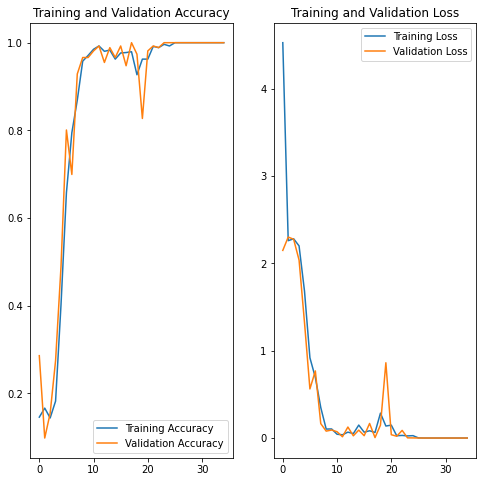

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.applications.vgg16 import VGG16, preprocess_input
class_subset = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
test_data_dir = r"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\data_distribution\data_distribution8-30\val"
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 
testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(150, 150),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 403 images belonging to 10 classes.


In [32]:
train = r"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\data_distribution\data_distribution8-30\train"
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)
traingen = train_generator.flow_from_directory(train,
                                               target_size=(150, 150),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

Found 794 images belonging to 10 classes.


In [33]:
#"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\implementation\tl_model_v1.weights.best_CNN.hdf5"

In [36]:
# Generate predictions
from keras.models import load_model
import numpy as np
#model = load_model('tl_model_v1.weights.best_CNN_80_20_1_2.hdf5')
model.load_weights('tl_model_v1.weights.best_CNN_80_20_1_2.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

403/403 [==============================] - 8s 19ms/step


<AxesSubplot:>

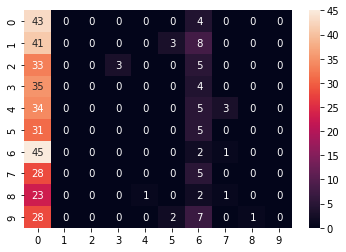

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(true_classes,vgg_pred_classes ),annot=True,fmt='2.0f')

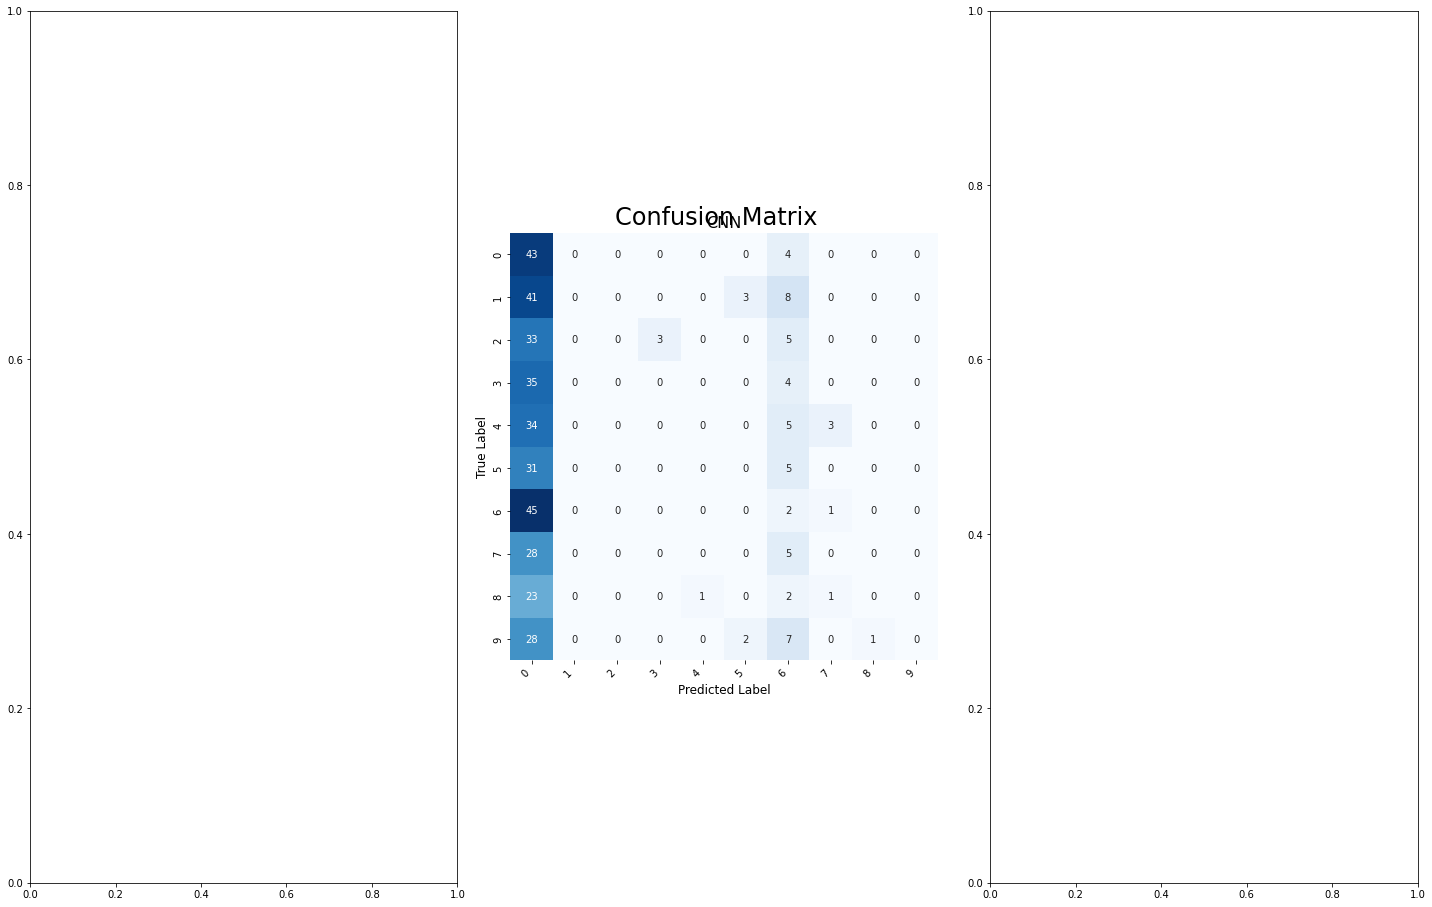

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="CNN")    

fig.suptitle("Confusion Matrix", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()